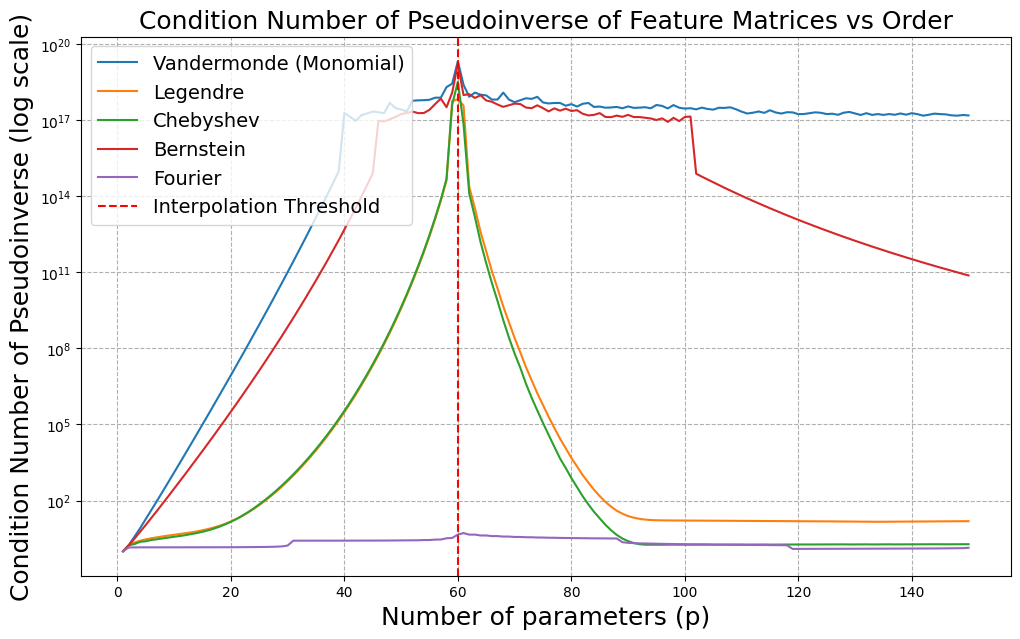

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import legendre, chebyshev
from math import comb

# ------------------------------
# Feature matrix definitions
# ------------------------------
def vandermonde_matrix(x, degree):
    return np.vander(x, N=degree, increasing=True)

def legendre_matrix(x, degree):
    n = len(x)
    L = np.zeros((n, degree))
    for i in range(degree):
        coeffs = np.zeros(i+1)
        coeffs[-1] = 1
        L[:, i] = legendre.legval(x, coeffs)
    return L

def chebyshev_matrix(x, degree):
    n = len(x)
    C = np.zeros((n, degree))
    for i in range(degree):
        coeffs = np.zeros(i+1)
        coeffs[-1] = 1
        C[:, i] = chebyshev.chebval(x, coeffs)
    return C

def bernstein_matrix(x, degree):
    t = (x + 1) / 2  # map [-1,1] -> [0,1]
    n = len(t)
    B = np.zeros((n, degree))
    p = degree - 1
    for k in range(degree):
        B[:, k] = comb(p, k) * (t**k) * ((1 - t)**(p - k))
    return B

def fourier_matrix(x, degree):
    n = len(x)
    d = degree
    F = np.zeros((n, d))
    F[:, 0] = 1  # DC component

    # Use same domain as x to avoid distortions
    x_fourier = x.copy()

    for k in range(1, d // 2 + 1):
        F[:, 2 * k - 1] = np.cos(2 * np.pi * k * x_fourier)
        if 2 * k < d:
            F[:, 2 * k] = np.sin(2 * np.pi * k * x_fourier)
    return F

# ------------------------------
# Parameters
# ------------------------------
n = 60
max_degree = 150
degrees = range(1, max_degree + 1)

# Uniformly spaced point [-1,1]
x = np.linspace(-1, 1-(1/n), n)

# Random points in [-1,1]
#x = np.random.uniform(-1, 1, n)

# ------------------------------
# Compute condition numbers of pseudoinverse
# ------------------------------
vand_cond_pinv = []
leg_cond_pinv = []
cheb_cond_pinv = []
bern_cond_pinv = []
fourier_cond_pinv = []

for p in degrees:
    V = vandermonde_matrix(x, p)
    L = legendre_matrix(x, p)
    C = chebyshev_matrix(x, p)
    B = bernstein_matrix(x, p)
    F = fourier_matrix(x, p)

    vand_cond_pinv.append(np.linalg.cond(np.linalg.pinv(V)))
    leg_cond_pinv.append(np.linalg.cond(np.linalg.pinv(L)))
    cheb_cond_pinv.append(np.linalg.cond(np.linalg.pinv(C)))
    bern_cond_pinv.append(np.linalg.cond(np.linalg.pinv(B)))
    fourier_cond_pinv.append(np.linalg.cond(np.linalg.pinv(F)))

# ------------------------------
# Plot
# ------------------------------
plt.figure(figsize=(12,7))
plt.semilogy(degrees, vand_cond_pinv, label='Vandermonde (Monomial)')
plt.semilogy(degrees, leg_cond_pinv, label='Legendre')
plt.semilogy(degrees, cheb_cond_pinv, label='Chebyshev')
plt.semilogy(degrees, bern_cond_pinv, label='Bernstein')
plt.semilogy(degrees, fourier_cond_pinv, label='Fourier')
plt.axvline(x=n, color='r', linestyle='--', label='Interpolation Threshold')
plt.xlabel('Number of parameters (p)', fontsize=18)
plt.ylabel('Condition Number of Pseudoinverse (log scale)', fontsize=18)
plt.title('Condition Number of Pseudoinverse of Feature Matrices vs Order', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, which='both', ls='--')
plt.savefig('condition_number_pinv_vs_order_random.pdf')
plt.show()


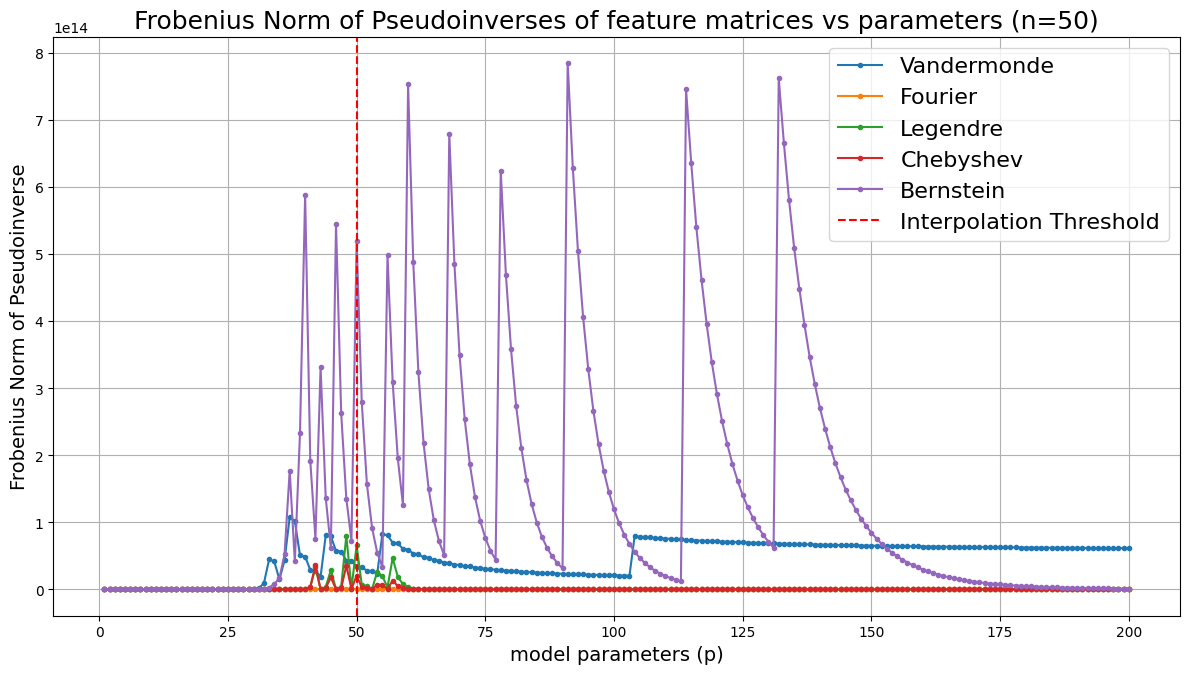

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import legvander
from numpy.polynomial.chebyshev import chebvander
from scipy.special import comb  # for Bernstein basis

#def generate_input_points(n):
    #return np.linspace(-1, 1, n)
    #return np.random.uniform(-1, 1, n)

def vandermonde_features(x, p):
    return np.vander(x, N=p+1, increasing=True)

def fourier_features(x, p):
    n = len(x)
    d = p
    F = np.zeros((n, d))
    F[:, 0] = 1  # DC component

    # Adjust domain for Fourier basis
    x_fourier = np.linspace(-1, 1 - (1/n), n) # Note if we change the domain, it completely changes its behavior, try making it [-1,1]

    for k in range(1, d // 2 + 1):
        F[:, 2 * k - 1] = np.cos(2 * np.pi * k * x_fourier)
        if 2 * k < d:
            F[:, 2 * k] = np.sin(2 * np.pi * k * x_fourier)
    return F

def legendre_features(x, p):
    return legvander(x, p)

def chebyshev_features(x, p):
    return chebvander(x, p)

def bernstein_features(x, p):
    # Rescale x from [-1, 1] to [0, 1]
    x_rescaled = (x + 1) / 2
    B = np.zeros((len(x_rescaled), p + 1))
    for i in range(p + 1):
        B[:, i] = comb(p, i) * (x_rescaled ** i) * ((1 - x_rescaled) ** (p - i))
    return B

def frobenius_norm(matrix):
    return np.linalg.norm(matrix, 'fro')

# Parameters
n = 50
max_order = 200
orders = list(range(1, max_order + 1))
norms = {
    'Vandermonde': [],
    'Fourier': [],
    'Legendre': [],
    'Chebyshev': [],
    'Bernstein': []
}

#x = generate_input_points(n)
x= np.random.uniform(-1, 1, n)

for p in orders:
    # Vandermonde
    V = vandermonde_features(x, p)
    norms['Vandermonde'].append(frobenius_norm(np.linalg.pinv(V)))

    # Fourier
    F = fourier_features(x, p)
    norms['Fourier'].append(frobenius_norm(np.linalg.pinv(F)))

    # Legendre
    L = legendre_features(x, p)
    norms['Legendre'].append(frobenius_norm(np.linalg.pinv(L)))

    # Chebyshev
    C = chebyshev_features(x, p)
    norms['Chebyshev'].append(frobenius_norm(np.linalg.pinv(C)))

    # Bernstein
    B = bernstein_features(x, p)
    norms['Bernstein'].append(frobenius_norm(np.linalg.pinv(B)))

# Plotting
plt.figure(figsize=(12, 7))

for name, values in norms.items():
    plt.plot(orders, values, label=name, marker='o', markersize=3)

plt.title(f'Frobenius Norm of Pseudoinverses of feature matrices vs parameters (n={n})',fontsize=18)
plt.xlabel('model parameters (p)',fontsize=14)
plt.ylabel('Frobenius Norm of Pseudoinverse',fontsize=14)
plt.axvline(x=n, color='r', linestyle='--', label='Interpolation Threshold')
plt.legend(fontsize=16)
#plt.xlim(20, 80)
#plt.ylim(0, 1e14)
plt.savefig('frobenius_norm_vs_parameters_2.pdf')
plt.grid(True)
plt.tight_layout()
plt.show()


